In [21]:
import torch # torch will allow us to create tensors.
import torch.nn as nn # torch.nn allows us to create a neural network.
import torch.nn.functional as F # nn.functional give us access to the activation and loss functions.
from torch.optim import SGD # optim contains many optimizers. Here, we're using SGD, stochastic gradient descent.

import pytorch_lightning as L # lightning has tons of cool tools that make neural networks easier
from torch.utils.data import TensorDataset, DataLoader # these are needed for the training data

import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

from pytorch_lightning.utilities.seed import seed_everything # this is added because people on different computers were
seed_everything(seed=42)

Global seed set to 42


42

<AxesSubplot:>

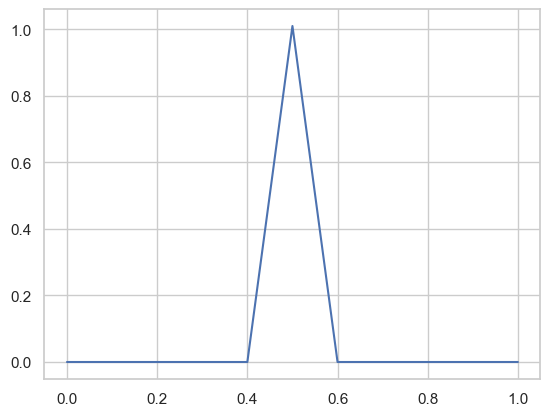

In [22]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        # initialize the weight and biases.
        super().__init__() # call initialization method for parent class - nn.Module
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85),  requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8),  requires_grad=False)
        self.w10 = nn.Parameter(torch.tensor(12.6),  requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0),  requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7),  requires_grad=False)
        self.final_bias = nn.Parameter(torch.tensor(-16.0),  requires_grad=False)

        # We have defined the initial guesses of the weight and the biases.

    def forward(self, input):

        input_to_top_relu = input* self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input* self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias

        output = F.relu(input_to_final_relu)

        return output

# To test the thing: We make a tensor having the input data.

input_doses = torch.linspace(start = 0, end = 1, steps = 11)

model = BasicLightning()

output_values =model(input_doses)


sns.set_style('whitegrid')
sns.lineplot(x= input_doses, y = output_values)

In [23]:
# When we are using Lightning - we need to keep the optimizer in the same cell.


# Time to forget the b(final) value:

class BasicLightningTrain(L.LightningModule):
    def __init__(self):
        # initialize the weight and biases.
        super().__init__() # call initialization method for parent class - nn.Module
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85),  requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8),  requires_grad=False)
        self.w10 = nn.Parameter(torch.tensor(12.6),  requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0),  requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7),  requires_grad=False)
        
        self.final_bias = nn.Parameter(torch.tensor(0.0),  requires_grad=True)

        self.learning_rate = 0.01 # This is a placeholder value and doesn't matter

        # We have defined the initial guesses of the weight and the biases.

    def forward(self, input):

        input_to_top_relu = input* self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input* self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias

        output = F.relu(input_to_final_relu)

        return output

    def configure_optimizers(self):
        return SGD(self.parameters(), lr = self.learning_rate)

    def training_step(self, batch, batch_idx): # takes batch of trainig data that we made using dataloader.
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i)** 2

        return loss

In [24]:
inputs = torch.tensor([0., 0.5, 1.] * 100)
labels = torch.tensor([0., 1., 0.] * 100)

dataset = TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)

In [25]:
model = BasicLightningTrain()

trainer = L.Trainer(max_epochs=20) 

# To make good use og the GPU:

# we can make changes in the trainer to find if we have GPU:

#trainer = L.Trainer(max_epochs=34, accelerator= "auto", devices="auto")


lr_find_results = trainer.tuner.lr_find(model,
                                        train_dataloaders=dataloader, # the training data
                                        min_lr=0.001, # minimum learning rate
                                        max_lr=1.0,   # maximum learning rate
                                        early_stop_threshold=None) # setting this to "None" tests all 100 candidate rates
new_lr = lr_find_results.suggestion()

print(f"lr_find() suggests {new_lr:.5f} for the learning rate.")

model.learning_rate = new_lr

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aaryan/opt/anaconda3/envs/pitorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 1752.36it/s]
Restoring states from the checkpoint path at /Users/aaryan/Documents/GitHub/PythonDataScience/Deep Learning/.lr_find_d846ab4f-439b-463b-bdea-73bc451fa922.ckpt


lr_find() suggests 0.00214 for the learning rate.


In [26]:
trainer.fit(model, train_dataloaders=dataloader)

print(model.final_bias.data)


  | Name | Type | Params
------------------------------
------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 300/300 [00:00<00:00, 513.35it/s, loss=3.35e-06, v_num=3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 300/300 [00:00<00:00, 511.08it/s, loss=3.35e-06, v_num=3]
tensor(-16.0070)


Text(0.5, 0, 'Dose')

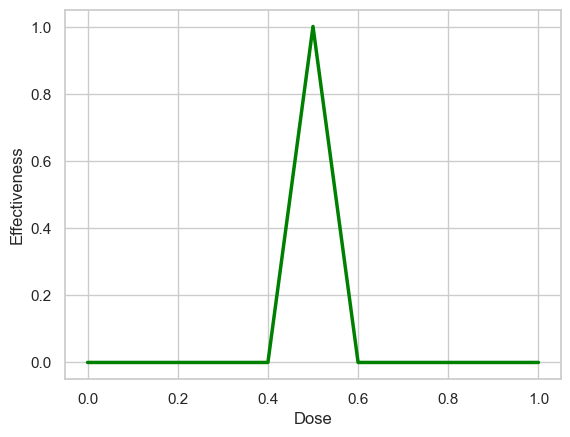

In [27]:
output_values = model(input_doses)
sns.set(style="whitegrid")
sns.lineplot(x=input_doses, 
             y=output_values.detach(), ## NOTE: we call detach() because final_bias has a gradient
             color='green', 
             linewidth=2.5)

plt.ylabel('Effectiveness')
plt.xlabel('Dose')
